In [45]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.15.0


In [46]:
dataset_path = "gs://cloud-training-demos/wine_quality/winequality-white.csv"

In [47]:
column_names = ['fixed_acidity','volatile_acidity','citric_acid','residual_sugar',
                'chlorides','free_sulfur_dioxide','total_sulfur_dioxide','density',
                'pH','sulphates','alcohol','quality']

In [48]:
raw_dataframe = pd.read_csv(dataset_path, names=column_names, header = 0, 
                      na_values = " ", comment='\t',
                      sep=";", skipinitialspace=True)

raw_dataframe = raw_dataframe.astype(float)
raw_dataframe['quality'] = raw_dataframe['quality'].astype(int)
dataframe = raw_dataframe.copy()

In [49]:
dataframe.isna().sum()

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [50]:
dataframe.tail()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7
4897,6.0,0.21,0.38,0.8,0.020,22.0,98.0,0.98941,3.26,0.32,11.8,6


In [51]:
data_stats = dataframe.describe()
data_stats = data_stats.transpose()
data_stats

,count,mean,std,min,25%,50%,75%,max
fixed_acidity,4898.0,6.854788,0.843868,3.80000,6.300000,6.80000,7.3000,14.20000
volatile_acidity,4898.0,0.278241,0.100795,0.08000,0.210000,0.26000,0.3200,1.10000
citric_acid,4898.0,0.334192,0.121020,0.00000,0.270000,0.32000,0.3900,1.66000
residual_sugar,4898.0,6.391415,5.072058,0.60000,1.700000,5.20000,9.9000,65.80000
chlorides,4898.0,0.045772,0.021848,0.00900,0.036000,0.04300,0.0500,0.34600
free_sulfur_dioxide,4898.0,35.308085,17.007137,2.00000,23.000000,34.00000,46.0000,289.00000
total_sulfur_dioxide,4898.0,138.360657,42.498065,9.00000,108.000000,134.00000,167.0000,440.00000
density,4898.0,0.994027,0.002991,0.98711,0.991723,0.99374,0.9961,1.03898
pH,4898.0,3.188267,0.151001,2.72000,3.090000,3.18000,3.2800,3.82000
sulphates,4898.0,0.489847,0.114126,0.22000,0.410000,0.47000,0.5500,1.08000


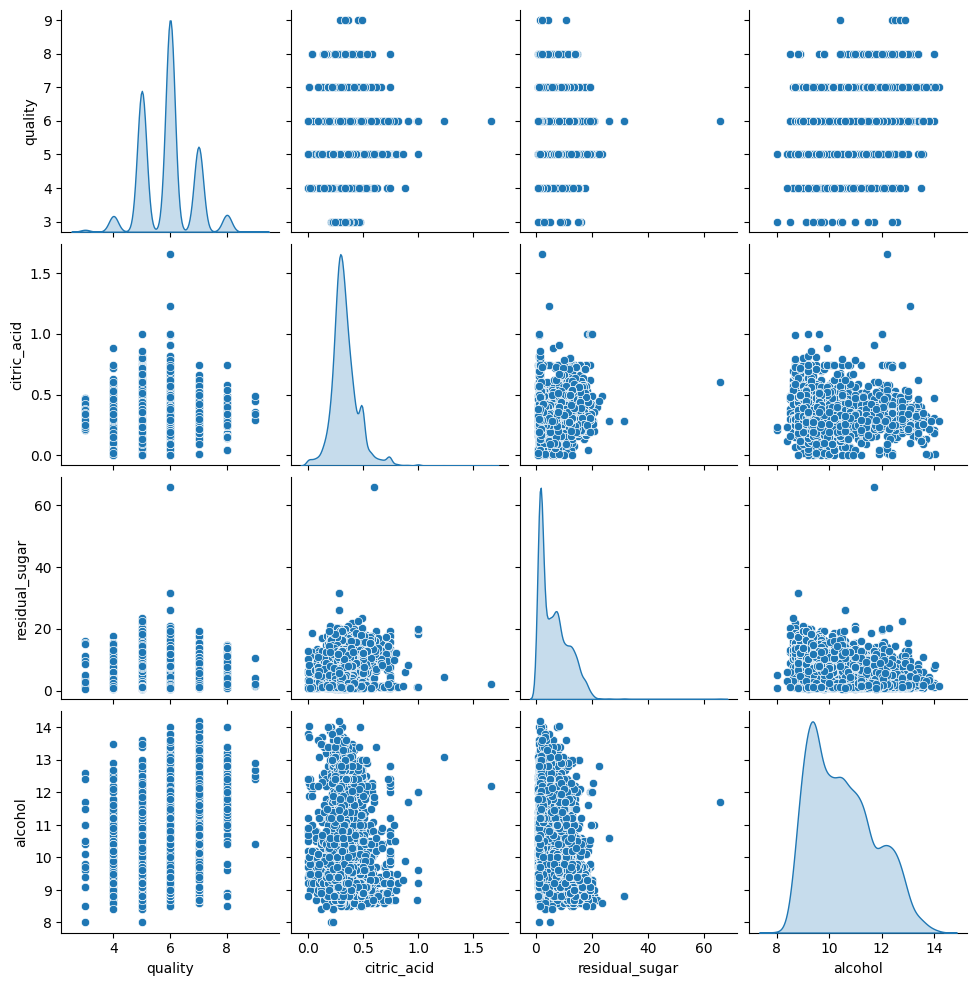

In [52]:
import seaborn as sns

sns.pairplot(dataframe[["quality", "citric_acid", "residual_sugar", "alcohol"]], diag_kind="kde")

In [53]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

3134 train examples
784 validation examples
980 test examples


In [54]:
def df_to_dataset(dataframe, epochs=10, shuffle=True, batch_size=64):
  dataframe = dataframe.copy()
  labels = tf.keras.utils.to_categorical(dataframe.pop('quality'), num_classes=11) #extracting the column which contains the training label
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.repeat(epochs).batch(batch_size)
  return ds

In [55]:
train_ds = df_to_dataset(train)
val_ds = df_to_dataset(val, shuffle=False)
test_ds = df_to_dataset(test, shuffle=False)

In [56]:
for feature_batch, label_batch in train_ds.take(1):
  print('Every feature:', list(feature_batch.keys()))
  print('A batch of citric acid:', feature_batch['citric_acid'])
  print('A batch of quality:', label_batch )

Every feature: ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol']
A batch of citric acid: tf.Tensor(
[0.32 0.28 0.31 0.22 0.26 0.19 0.48 0.2  0.3  0.32 0.33 0.21 0.2  0.37
 0.3  0.25 0.37 0.3  0.29 0.42 0.32 0.33 0.37 0.34 0.74 0.24 0.42 0.32
 0.09 0.26 0.33 0.42 0.27 0.27 0.35 0.2  0.36 0.3  0.38 0.27 0.31 0.3
 0.21 0.17 0.26 0.38 0.58 0.32 0.39 0.36 0.3  0.3  0.36 0.42 0.4  0.32
 0.24 0.3  0.35 0.29 0.33 0.49 0.32 0.24], shape=(64,), dtype=float64)
A batch of quality: tf.Tensor(
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0

In [57]:
from tensorflow import feature_column

feature_columns = []

fixed_acidity = tf.feature_column.numeric_column('fixed_acidity')
bucketized_fixed_acidity = tf.feature_column.bucketized_column(
    fixed_acidity, boundaries=[3., 5., 7., 9., 11., 13., 14.])
feature_columns.append(bucketized_fixed_acidity)

volatile_acidity = tf.feature_column.numeric_column('volatile_acidity')
bucketized_volatile_acidity = tf.feature_column.bucketized_column(
    volatile_acidity, boundaries=[0., 0.2, 0.4, 0.6, 0.8, 1.])
feature_columns.append(bucketized_volatile_acidity)

citric_acid = tf.feature_column.numeric_column('citric_acid')
bucketized_citric_acid = tf.feature_column.bucketized_column(
    citric_acid, boundaries=[0., 0.4, 0.7, 1.0, 1.3, 1.8])
feature_columns.append(bucketized_citric_acid)

residual_sugar = tf.feature_column.numeric_column('residual_sugar')
bucketized_residual_sugar = tf.feature_column.bucketized_column(
    residual_sugar, boundaries=[0.6, 10., 20., 30., 40., 50., 60., 70.])
feature_columns.append(bucketized_residual_sugar)

chlorides = tf.feature_column.numeric_column('chlorides')
bucketized_chlorides = tf.feature_column.bucketized_column(
    chlorides, boundaries=[0., 0.1, 0.2, 0.3, 0.4])
feature_columns.append(bucketized_chlorides)

free_sulfur_dioxide = tf.feature_column.numeric_column('free_sulfur_dioxide')
bucketized_free_sulfur_dioxide = tf.feature_column.bucketized_column(
    free_sulfur_dioxide, boundaries=[1., 50., 100., 150., 200., 250., 300.])
feature_columns.append(bucketized_free_sulfur_dioxide)

total_sulfur_dioxide = tf.feature_column.numeric_column('total_sulfur_dioxide')
bucketized_total_sulfur_dioxide = tf.feature_column.bucketized_column(
    total_sulfur_dioxide, boundaries=[9., 100., 200., 300., 400., 500.])
feature_columns.append(bucketized_total_sulfur_dioxide)

density = tf.feature_column.numeric_column('density')
bucketized_density = tf.feature_column.bucketized_column(
    density, boundaries=[0.9, 1.0, 1.1])
feature_columns.append(bucketized_density)

pH = tf.feature_column.numeric_column('pH')
bucketized_pH = tf.feature_column.bucketized_column(
    pH, boundaries=[2., 3., 4.])
feature_columns.append(bucketized_pH)

sulphates = tf.feature_column.numeric_column('sulphates')
bucketized_sulphates = tf.feature_column.bucketized_column(
    sulphates, boundaries=[0.2, 0.4, 0.7, 1.0, 1.1])
feature_columns.append(bucketized_sulphates)

alcohol = tf.feature_column.numeric_column('alcohol')
bucketized_alcohol = tf.feature_column.bucketized_column(
    alcohol, boundaries=[8., 9., 10., 11., 12., 13., 14.])
feature_columns.append(bucketized_alcohol)


feature_columns

[BucketizedColumn(source_column=NumericColumn(key='fixed_acidity', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 14.0)),
 BucketizedColumn(source_column=NumericColumn(key='volatile_acidity', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(0.0, 0.2, 0.4, 0.6, 0.8, 1.0)),
 BucketizedColumn(source_column=NumericColumn(key='citric_acid', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(0.0, 0.4, 0.7, 1.0, 1.3, 1.8)),
 BucketizedColumn(source_column=NumericColumn(key='residual_sugar', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(0.6, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0)),
 BucketizedColumn(source_column=NumericColumn(key='chlorides', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(0.0, 0.1, 0.2, 0.3, 0.4)),
 BucketizedColumn(source_column=NumericColumn(key='free_sulfur_dioxide',

In [58]:
# Create a feature layer from the feature columns

feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [59]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(8, activation='relu'),
  layers.Dense(8, activation='relu'),
  layers.Dense(11, activation='softmax')
])

In [60]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.fit(train_ds,
          validation_data=val_ds,
          epochs=50)

Epoch 1/50
490/490 [==============================] - 3s 4ms/step - loss: 1.3646 - accuracy: 0.4504 - val_loss: 1.1510 - val_accuracy: 0.5038
Epoch 2/50
490/490 [==============================] - 2s 3ms/step - loss: 1.1458 - accuracy: 0.5112 - val_loss: 1.1054 - val_accuracy: 0.5255
Epoch 3/50
490/490 [==============================] - 2s 3ms/step - loss: 1.1147 - accuracy: 0.5291 - val_loss: 1.1013 - val_accuracy: 0.5319
Epoch 4/50
490/490 [==============================] - 2s 3ms/step - loss: 1.1007 - accuracy: 0.5361 - val_loss: 1.0997 - val_accuracy: 0.5230
Epoch 5/50
490/490 [==============================] - 1s 3ms/step - loss: 1.0915 - accuracy: 0.5387 - val_loss: 1.0939 - val_accuracy: 0.5281
Epoch 6/50
490/490 [==============================] - 1s 3ms/step - loss: 1.0842 - accuracy: 0.5385 - val_loss: 1.0953 - val_accuracy: 0.5204
Epoch 7/50
490/490 [==============================] - 2s 3ms/step - loss: 1.0783 - accuracy: 0.5375 - val_loss: 1.0979 - val_accuracy: 0.5153
Epoch 

### Wykorzystanie modelu

In [61]:
predictions = model.predict(feature_batch)

classes_x = np.argmax(predictions,axis=1)
classes_x

2/2 [==============================] - 0s 8ms/step


array([5, 6, 6, 6, 6, 5, 6, 6, 5, 7, 6, 6, 5, 5, 6, 6, 5, 6, 5, 6, 6, 6,
       6, 7, 5, 5, 7, 7, 5, 6, 6, 6, 5, 5, 6, 5, 5, 8, 6, 5, 6, 6, 6, 5,
       6, 5, 6, 6, 6, 6, 8, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 7],
      dtype=int64)

In [62]:
len(classes_x)

64

In [66]:
predictions2 = model.predict(test_ds)
# predictions

classes_x2 = np.argmax(predictions2,axis=1)
len(classes_x2)

  1/154 [..............................] - ETA: 5s

154/154 [==============================] - 0s 2ms/step


9800

In [70]:
classes_x2

array([5, 6, 6, ..., 5, 5, 6], dtype=int64)